# Metody pozyskiwania wiedzy z danych - projekt zaliczeniowy

Narzędzie pozwalające użytkownikowi na estymację ceny mieszkania w zależności od podanych parametrów.

Skład zespołu: 
- Zapalski, 
- Szkatuła, 
- Pietrzyk, 
- Śmiałowski

## To do:
- opis zestawu danych i jego źródła
- analiza eksploracyjna zestawu danych (info o zmiennych, statystki opisowe, rozkłady, korelacje, .... )
- analiza wizualna (przedstawienie danych w formie wizualnej, przeprowadzenie analiz zależności pomiędzy zmiennymi, heatmapy z najczęstszymi miejscami, ... )
- ocztszczenie danych (outliery, NA itd. )
- pierwszy model
- feature enginering
- zastosowanie różnych typów modeli (?)
- hyperparameters tuning na najlepszym modelu
- stworzenie coś na wzór UX w noteboooku

## Notes:
- zrobić coś na wzór UI dla użytkownika końcowego (może być jako suwaczki w jupyterze albo API)
- lista dzielnic i miast, feature enginering na zmiennej adres tak zeby wyciagnac dzielnice
- analiza danych, statystki opisowe, wykresy i mapki

## Podstawowe informacje o danych

Dane wykorzystane w poniższym projekcie zostały pobrane z serwisu Kaggle. Są one ogólnodostępne pod tym linkiem: https://www.kaggle.com/dawidcegielski/house-prices-in-poland.

Bardzo zależało nam, aby dane dotyczyły cen mieszkań w Polsce i aby były one dosyć aktualne, co udało nam się osiągnąć, gdyż dane pochodzą z polskiego rynku w lutym 2021.

Zbiór danych tworzy 10 zmiennych:
- address - pełny adres pod którym znajduje się omawiane mieszkanie,
- city - miasto w którym znajduje się analizowane mieszkanie,
- floor - piętro na którym znajduje się mieszkanie,
- id - identyfikator mieszkania,
- latitude - szerokość geograficzna mieszkania,
- longitiude - długość geograficzna miszkania,
- price - cena mieszkania (w PLN),
- rooms - liczba pokoi w omawianym mieszkaniu,
- sq - liczba metrów kwadratowych w danym mieszkaniu,
- year - rok, w którym zostało wybudowane mieszkanie.

## Code

In [22]:
import pandas as pd
import matplotlib as plt
import numpy as np

from sklearn.metrics import mean_squared_error, r2_score

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.tree import DecisionTreeRegressor
import catboost as ctb

In [23]:
!pwd

/c/Users/Kamil/Downloads/apartments-main


In [24]:
df = pd.read_csv("data/Houses.csv", encoding='latin-1',index_col=0)
df.head()

,address,city,floor,id,latitude,longitude,price,rooms,sq,year
0,Podgórze Zab³ocie Stanis³awa Klimeckiego,Kraków,2.0,23918.0,50.049224,19.970379,749000.0,3.0,74.05,2021.0
1,Praga-Po³udnie Grochowska,Warszawa,3.0,17828.0,52.249775,21.106886,240548.0,1.0,24.38,2021.0
2,Krowodrza Czarnowiejska,Kraków,2.0,22784.0,50.066964,19.920025,427000.0,2.0,37.00,1970.0
3,Grunwald,Poznañ,2.0,4315.0,52.404212,16.882542,1290000.0,5.0,166.00,1935.0
4,Ochota Gotowy budynek. Stan deweloperski. Osta...,Warszawa,1.0,11770.0,52.212225,20.972630,996000.0,5.0,105.00,2020.0


### Podstawowe statystyki opisowe

In [25]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
floor,23764.0,2.808744,2.463467,0.000000,1.000000,2.000000,4.000000,1.000000e+01
id,23764.0,15621.964484,8617.293898,1.000000,8420.750000,15637.500000,23111.250000,3.030800e+04
latitude,23764.0,51.374874,1.099836,49.933056,50.066489,52.193987,52.267594,5.443524e+01
longitude,23764.0,19.861773,1.447186,4.204796,19.916563,19.999330,20.996180,3.031940e+01
price,23764.0,649353.647809,532696.986646,5000.000000,411546.125000,520000.000000,699999.000000,1.500000e+07
rooms,23764.0,2.620771,0.996530,1.000000,2.000000,3.000000,3.000000,1.000000e+01
sq,23764.0,102.724910,6533.687932,8.800000,42.000000,53.895000,68.915000,1.007185e+06
year,23764.0,2000.551170,48.314020,70.000000,1985.000000,2019.000000,2021.000000,2.980000e+03


Jak można zauważyć, w przypadku wszystkich zmiennych liczba uwzględnionych obserwacji jest taka sama i wynosi 23764, co oznacza iż w zbiorze nie występują żadne braki danych. Zauważyć można bardzo duże wartości odchylenia standardowego jak również samej średniej w przypadku zmiennej price, lecz jest to naturalne, gdyż ceny mieszkań są stosunkowo dużymi wartościami. Bardzo małe wartości odchyleń standardowych dla zmiennych dotyczących szerokości oraz długości geograficznej wynikają z faktu, iż wszystkie mieszkania uwzględnione w bazie danych znajdują się w jednym kraju. Uwagę zwraca również spora rozbieżnośc pomiędzy średnią a medianą dla ilości metrów kwadratowych w mieszkaniu. Taka informacja sugeruje, iż w zbiorze danych występują przypadki ekstremalnie dużych mieszkań.

### Badanie korelacji

Aby ostatecznie dokonać wyboru które zmienne zostaną wykorzystane do stworzenia modelu zdecydowano się na sprawdzenie korelacji pomiędzy zmiennymi. Korelacją nazywa się związek pomiędzy dwoma zmiennymi losowymi, który można określić jako podobieństwo zachowania bądź współzachowanie. Z korelacją ściśle powiązane jest pojęcie współliniowości, które wskazuje na spadek znaczenia zmiennych objaśniających. W trakcie analizy powinno się oczekiwać, iż nie dojdzie do współliniowości, czyli przyjmując wskaźnik tolerancji na poziomie 0,1 korelacja między zmiennymi nie powinna przekroczyć wartości 0,9, ani nie osiągnąć wartości mniejszej od -0,9.

<AxesSubplot:>

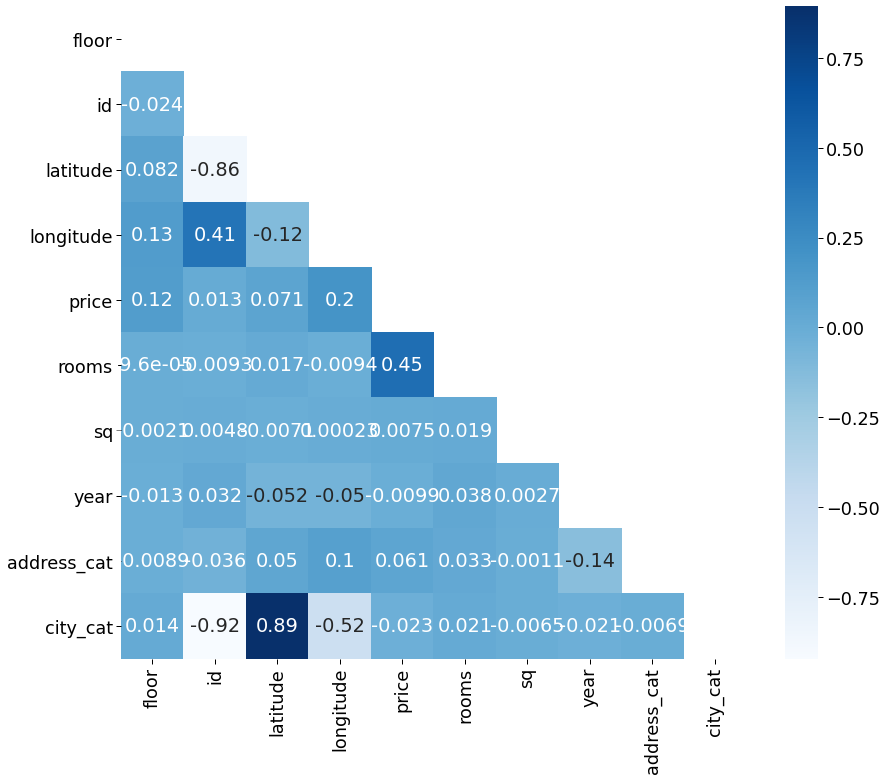

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14,12))
sns.set_context('paper', font_scale=2)

corr= df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, annot=True, cmap='Blues', mask=mask)

Jak można zauważyć, w analizowanym zbiorze danych nie ma powodów do usunięcia jakiejkolwiek ze zmiennych. Taki przypadek mógłby dotyczyć identyfikatora dla mieszkania, lecz ta zmienna nie zostanie wykorzystana w tworzeniu modelu, gdyż tak naprawdę nie opisuje ona sprzedawanego mieszkania.

### Oczyszczanie danych

W celu oczyszczenia danych podjęto decyzję, iż usunięte zostaną wartości poniżej oraz powyżej określonych progów dla poszczególnych zmiennych. Taka decyzja pozwoli na usunięcie obserwacji zawierających ekstremalne wartości, ale również takowych, które mogły zostać wpisane z błędami. W tym celu stworzono listę zawierającą obserwacje dotyczące mieszkań posiadających mniej niż 10 metrów kwadratowych, bądź też więcej niż 450 metrów kwadratowych. Takowe obserwacje usunięto ze zbioru.

In [6]:
usuwanie_metry = df[(df['sq'] > 450) | (df['sq'] < 10)].index.tolist()

# Remove 
df = df.drop(usuwanie_metry)

Usunięto również obserwacje zawierające błędnie wpisane daty wybudowania mieszkania. 

In [7]:
# Create list of rows with mistakenly year value
usuwanie_lata = df[(df['year'] > 2023) | (df['year'] < 1000)].index.tolist()

# Remove 
df = df.drop(usuwanie_lata)

# Feature engineering - dzielnice

In [8]:
df.sample(40)

,address,city,floor,id,latitude,longitude,price,rooms,sq,year
18539,Wilanów Adama Branickiego,Warszawa,0.0,15017.0,52.154572,21.070621,1439360.0,3.0,110.72,2012.0
2188,Bia³o³êka Mochtyñska,Warszawa,3.0,18261.0,52.351810,21.038792,355000.0,2.0,46.00,2019.0
2221,Bie¿anów-Prokocim Bie¿anów Aleksandry,Kraków,4.0,19253.0,50.012587,20.019409,292000.0,2.0,35.00,1980.0
8164,Nowe Miasto G³ówna Smolna 10,Poznañ,3.0,4999.0,52.422074,16.966487,380760.0,3.0,50.10,2020.0
21948,Bemowo,Warszawa,3.0,17035.0,52.238974,20.913288,564200.0,3.0,56.62,2022.0
20697,ma³opolskie,Kraków,7.0,24040.0,50.061947,19.936856,429000.0,2.0,44.21,2021.0
14616,Grunwald,Poznañ,0.0,4477.0,52.404212,16.882542,359500.0,2.0,42.32,2019.0
9072,Dêbniki Ruczaj Czerwone Maki,Kraków,2.0,20786.0,50.013003,19.888723,560000.0,3.0,52.59,2006.0
22637,Mokotów ul. Jana Paw³a Woronicza,Warszawa,6.0,6944.0,52.189742,21.005474,917000.0,3.0,61.45,2020.0
17256,Podgórze Jana D³ugosza,Kraków,2.0,22783.0,50.042672,19.942077,1294852.0,4.0,87.49,2021.0


Możemy zauważyć, że w kolumnie *address* każda obserwacja zaczyna się od nazwy dzielnicy.

To, że nazwy są źle zakodowane nas nie intereseuje, model i tak będzie widział to jako osobne liczby.

Problemem może okazać się rozróżnienie podobych nazw dzielnic np. Wola w Warszawie i Wola Duchacka w Krakowie oraz różna liczba słów w nazwie dzielnicy (Śródmieście - 1 , Stare Miasto - 2 itd. )

In [9]:
df["address"].value_counts()[:30]

Mokotów                                   426
Wola                                      383
Nowe Miasto Malta ul. Katowicka           377
ródmiecie                               352
Bia³o³êka                                 248
Mistrzejowice ul. Piasta Ko³odzieja       224
Mistrzejowice                             221
Praga-Po³udnie                            216
Bemowo                                    204
Stare Miasto Naramowice ul. Czarnucha     199
Praga-Po³udnie Goc³aw                     193
Podgórze                                  191
Nowe Miasto Rataje                        181
Grzegórzki                                178
Stare Miasto                              178
Ursynów                                   174
Pr¹dnik Bia³y                             174
Ochota                                    159
Krowodrza                                 142
Nowa Huta Czy¿yny Nowohucka 46            142
Podgórze ul. Stanis³awa Klimeckiego       138
Mokotów ul. Domaniewska 34B       

wyciągnięcie np. top20 pod względem częstości występowania nie rozwiąże problemu, nowe osiedla podawane z ulica (Mistrzejowice ul. Piasta Ko³odzieja) ze sporą ilością ofert zawyżają tą listę

Możliwe rozwiązania:

    -skonstruowanie słownika z nazwami dzielnic oraz poprawienie danych, tak aby wyświetlały się poprawnie (formatowanie
    -ewentualnie ręczne poprawienie każdego rekordu

In [10]:
wwa= ["Bemowo",
"Białołęka",
"Bielany",
"Mokotów",
"Ochota",
"Praga Południe",
"Praga Północ",
"Rembertów",
"Śródmieście",
"Targówek",
"Ursus",
"Ursynów",
"Wawer",
"Wesoła",
"Wilanów",
"Włochy",
"Wola",
"Żoliborz"]
wwa

['Bemowo',
 'Białołęka',
 'Bielany',
 'Mokotów',
 'Ochota',
 'Praga Południe',
 'Praga Północ',
 'Rembertów',
 'Śródmieście',
 'Targówek',
 'Ursus',
 'Ursynów',
 'Wawer',
 'Wesoła',
 'Wilanów',
 'Włochy',
 'Wola',
 'Żoliborz']

Stworzono również histogram ukazujący liczbę obserwacji dla poszczególnych cen, nie uwzględniając podziałów pomiędzy miastami.

Text(0.5, 1.0, 'Histogram cen mieszkań')

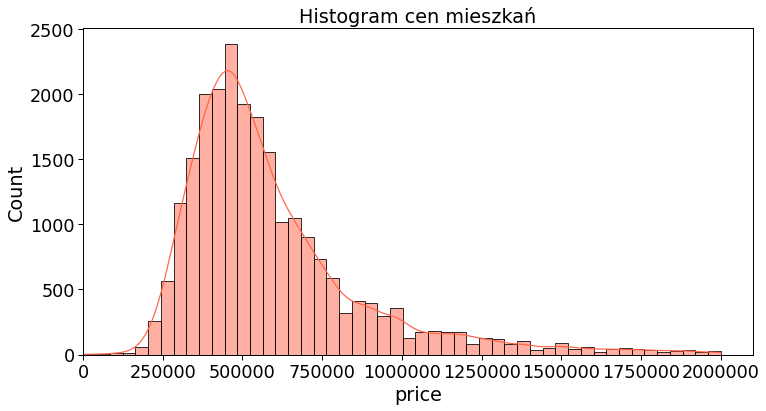

In [11]:
plt.figure(figsize=(12,6))
plt.ticklabel_format(style='plain', axis='x')
g = sns.histplot(x = 'price', data = df[df['price'] < 2000000], bins = 50, color = 'tomato', 
                 kde = True)
g.set(xlim=(0, None))
g.set_title('Histogram cen mieszkań')

Zdecydowano, iż pomocny w interpretacji będzie również wykres ukazujący rozkład obserwacji dla cen mieszkań w zależności od roku jego wybudowania.

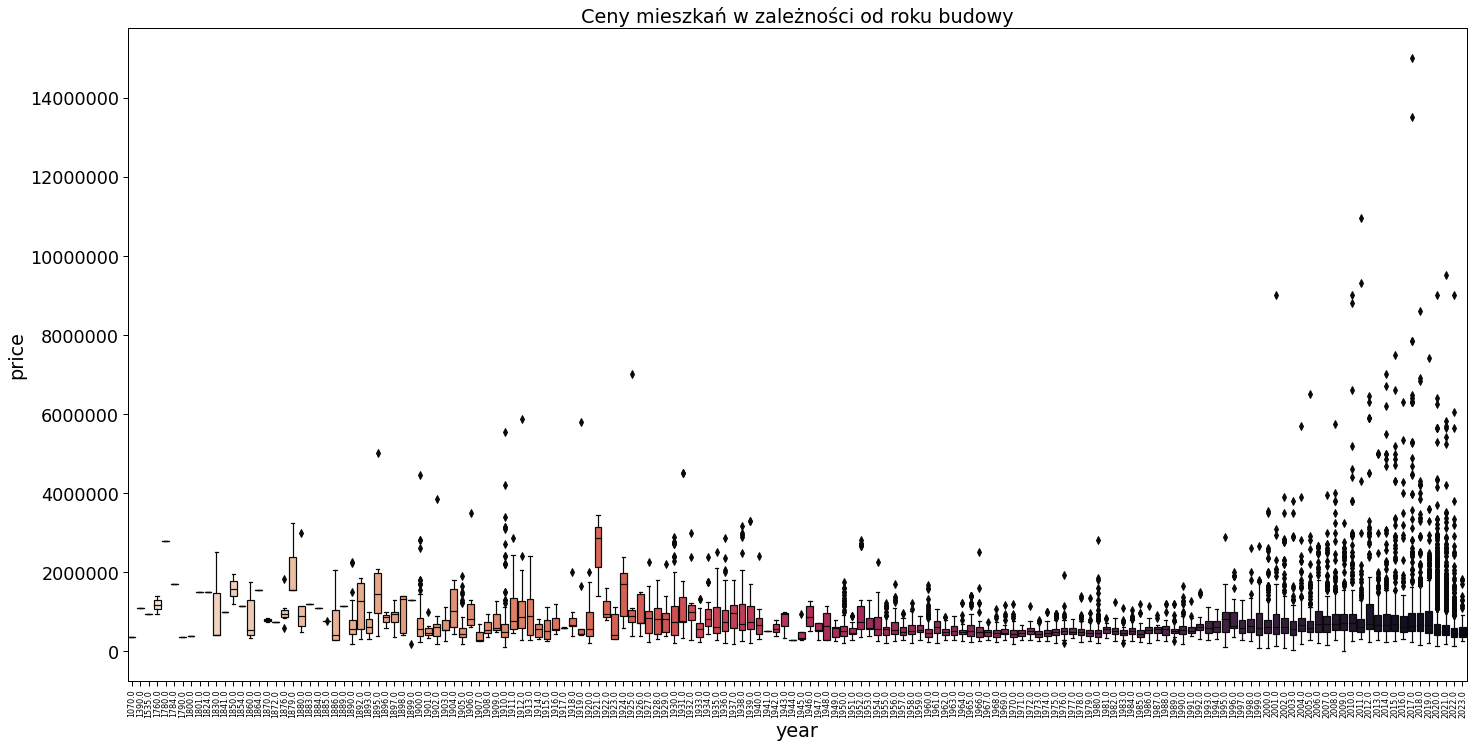

In [12]:
plt.figure(figsize=(24,12))
plt.ticklabel_format(style='plain', axis='y')
plt.xticks(fontsize=8, rotation=90)
g = sns.boxplot(x = 'year', data = df, y = 'price', 
                palette = 'rocket_r').set_title('Ceny mieszkań w zależności od roku budowy')

Jak można zauważyć, poza kilkoma przypadkami zdecydowanie można zauważyć wyższe ceny mieszkań dla nowowybudowanych mieszkań. Jest to dosyć naturalna obserwacja i wynika ona z komfortu oraz możliwości, jakie dają nowe mieszkania. Chodzi tutaj chociażby o korzystanie z wind, podziemnych parkingów czy usprawnień dla osób niepełnosprawnych.

Ponadto uznano, iż warto będzie również przeanalizować oferty z dwóch największych miast ze zbioru danych pod kątem lokalizacji mieszkań. Chodzi w tym przypadku o mieszkania znajdujące się w Krakowie oraz w Warszawie.

In [13]:
import folium
from folium import plugins
from folium.plugins import HeatMap, FastMarkerCluster
wwa_szerokosc = df[df['city'] == "Warszawa"].latitude.tolist()
wwa_dlugosc = df[df['city'] == "Warszawa"].longitude.tolist()
wwa_data = np.column_stack((wwa_szerokosc, wwa_dlugosc))

m = folium.Map(location=[52.235, 21.035], zoom_start=11, tiles="Stamen Terrain")

HeatMap(wwa_data).add_to(folium.FeatureGroup(name='Heat Map').add_to(m))
folium.LayerControl().add_to(m)

m

In [14]:
import folium
from folium import plugins
from folium.plugins import HeatMap, FastMarkerCluster
krk_szerokosc = df[df['city'] == "Kraków"].latitude.tolist()
krk_dlugosc = df[df['city'] == "Kraków"].longitude.tolist()
krk_data = np.column_stack((krk_szerokosc, krk_dlugosc))

m = folium.Map(location=[50.063367, 19.935186], zoom_start=11, tiles="Stamen Terrain")

HeatMap(krk_data).add_to(folium.FeatureGroup(name='Heat Map').add_to(m))
folium.LayerControl().add_to(m)

m

Jak można zauważyć, zdecydowana większość ofert uwzględnionych w bazie znajduje się w okolicy centrum obu miast. Szczególnie zaobserwować to zjawisko można w przypadku Warszawy. W przypadku Krakowa można mówić o całkiem dużej ilości pojawiających się domów do kupienia również w miejscowościach położonych blisko Krakowa. Szczególnie dotyczy to Krzeszowic, skąd dojazd do centrum Krakowa jest bardzo łatwy (pociąg dojeżdżający bezpośrednio do Krakowa Głównego).

# Model

In [27]:
# wybranie zmiennych jakościowych
obj_feats = list(df.select_dtypes(np.object).columns)

# zamiana ich na liczby
for feat in obj_feats:
    df["{}_cat".format(feat)] = df[feat].factorize()[0]

black_list = ["id","address", "city"]

feats = df.select_dtypes(include=[np.number, np.bool]).columns
feats = [x for x in feats if x not in black_list]

X = df[feats].to_numpy()
y = df["price"].to_numpy()

# podział na train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [16]:
model = ctb.CatBoostRegressor(verbose=False)
#cross_val_score(model, X_train, y_train, cv=3, scoring='r2')

In [17]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [18]:
df["price"].median()

520058.0

In [19]:
print ( r2_score(y_test, y_pred), mean_squared_error(y_test, y_pred, squared=False) )

0.9353907938515589 138414.41522702336


# Explainer Dashboard

In [20]:
from explainerdashboard import ClassifierExplainer, ExplainerDashboard

TypeError: an integer is required (got type bytes)

In [ ]:
## Scores

## Catboost - no parameters - 0.932 r2 - 147359 mse